In [ ]:
#for bucket iterator
!pip install torch==1.8.0 torchtext==0.9.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 735.5/735.5 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 26.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.8.0 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.8.0 which is incompatible.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but 

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import random
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
from torchtext.legacy.data import Field , BucketIterator ,TabularDataset
from torchtext.legacy import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Dakshina.zip

Archive:  /content/drive/MyDrive/Dakshina.zip
   creating: Dakshina Dataset/
   creating: Dakshina Dataset/hi/
   creating: Dakshina Dataset/hi/lexicons/
  inflating: Dakshina Dataset/hi/lexicons/hi.translit.sampled.dev.tsv  
  inflating: Dakshina Dataset/hi/lexicons/hi.translit.sampled.test.tsv  
  inflating: Dakshina Dataset/hi/lexicons/hi.translit.sampled.train.tsv  


In [ ]:
train_data = pd.read_csv('/content/Dakshina Dataset/hi/lexicons/hi.translit.sampled.train.tsv',sep = '\t', header = None)
test_data = pd.read_csv('/content/Dakshina Dataset/hi/lexicons/hi.translit.sampled.test.tsv',sep = '\t', header = None)
val_data = pd.read_csv('/content/Dakshina Dataset/hi/lexicons/hi.translit.sampled.dev.tsv',sep = '\t', header = None)

In [ ]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(44204, 2)
(4502, 2)
(4358, 2)


In [ ]:
train_data.head()

,0,1,2
0,अं,an,3
1,अंकगणित,ankganit,3
2,अंकल,uncle,4
3,अंकुर,ankur,4
4,अंकुरण,ankuran,3


#Loading dataset

In [ ]:
data=pd.read_csv('/content/Dakshina Dataset/hi/lexicons/hi.translit.sampled.train.tsv',delimiter='\t',header=None)
data = data.iloc[:, :-1]
data.to_csv('/content/Dakshina Dataset/hi/lexicons/hi.translit.sampled.train.tsv',sep='\t',index=False,header=False)

data=pd.read_csv('/content/Dakshina Dataset/hi/lexicons/hi.translit.sampled.test.tsv',delimiter='\t',header=None)
data = data.iloc[:, :-1]
data.to_csv('/content/Dakshina Dataset/hi/lexicons/hi.translit.sampled.test.tsv',sep='\t',index=False,header=False)

data=pd.read_csv('/content/Dakshina Dataset/hi/lexicons/hi.translit.sampled.dev.tsv',delimiter='\t',header=None)
data = data.iloc[:, :-1]
data.to_csv('/content/Dakshina Dataset/hi/lexicons/hi.translit.sampled.dev.tsv',sep='\t',index=False,header=False)

In [ ]:
def tokenize_word(word):
  return ['<SOS>'] + list(word) + ['<EOS>']

In [ ]:
hindi = Field(tokenize = tokenize_word)
english = Field(tokenize = tokenize_word,lower=True)

In [ ]:
fields = [('output',hindi),('input',english)]

In [ ]:
train_data =TabularDataset(
    path='/content/Dakshina Dataset/hi/lexicons/hi.translit.sampled.train.tsv',
    format='tsv',
    fields=fields,
    skip_header=False
)
test_data =TabularDataset(
    path='/content/Dakshina Dataset/hi/lexicons/hi.translit.sampled.test.tsv',
    format='tsv',
    fields=fields,
    skip_header=False
)
val_data =TabularDataset(
    path='/content/Dakshina Dataset/hi/lexicons/hi.translit.sampled.dev.tsv',
    format='tsv',
    fields=fields,
    skip_header=False
)

In [ ]:
# Build the vocabulary
english.build_vocab(train_data)
hindi.build_vocab(train_data)

In [ ]:
def evaluate_model(model):
  model.eval()
  preds=[]
  acts=[]

  pad_idx = hindi.vocab.stoi['<pad>']
  criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

  with torch.no_grad():
    test_loss=0.0
    for batch_idx,batch in enumerate(test_iterator):

      input_data = batch.input.to(device)
      target_data = batch.output.to(device)
      output=model(input_data,target_data)
      output = output[1:].reshape(-1,output.shape[2])
      target_data=target_data[1:].reshape(-1)

      output_max = output.argmax(dim=-1)
      test_loss+=criterion(output,target_data)


      preds.extend(output_max.cpu().numpy().flatten())
      acts.extend(target_data.cpu().numpy().flatten())

    corr_matrix = np.corrcoef(preds, acts)
    test_loss = float(float(test_loss)/float(len(test_iterator)))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.show()

    return test_loss


In [ ]:
def write_train_log(Loss,n_epochs,model_path,string_split):
  epochs=list(range(1,n_epochs))
  with open(model_path,'a') as f:
    f.write("\n")
    f.write("\t\t\t\t\t\t\t")
    f.write(string_split)
    f.write("\n")
    df=pd.concat([pd.Series(epochs,name='Epochs'),pd.Series(Loss,name='Loss')],axis=1)
    df_to_string=df.to_string(header=True,index=False)
    f.write(df_to_string)
    f.close()

#Question no:01

#LSTM

In [ ]:
class Encoder(nn.Module):

  def __init__(self,input_size,embedding_size,n_hidden_layers,hidden_layer_size,drop_out=0.0):
    super(Encoder,self).__init__()
    self.dropout = nn.Dropout(p=drop_out)
    self.embedding = nn.Embedding(input_size,embedding_size)
    self.lstm = nn.LSTM(embedding_size,hidden_layer_size,n_hidden_layers,dropout=drop_out)

  def forward(self,x):
    embedding = self.dropout(self.embedding(x))
    outputs,(hidden,cell) = self.lstm(embedding)

    return hidden,cell

In [ ]:
class Decoder(nn.Module):

  def __init__(self,input_size,embedding_size,hidden_size,output_size,n_hidden_layers,drop_out=0.0):
    super(Decoder,self).__init__()

    self.dropout=nn.Dropout(p=drop_out)
    self.embedding = nn.Embedding(input_size, embedding_size)
    self.lstm = nn.LSTM(embedding_size, hidden_size, n_hidden_layers, dropout=drop_out)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self,x,hidden,cell):
    x=x.unsqueeze(0)
    embedding = self.dropout(self.embedding(x))
    outputs, (hidden, cell) = self.lstm(embedding, (hidden, cell))
    out=self.fc(outputs)
    out=out.squeeze(0)

    return out,hidden,cell


In [ ]:
class seq2seq(nn.Module):
  def __init__(self,encoder,decoder):
    super(seq2seq, self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self,src,trg,teacher_force_ratio=0.5):
    batch_size = src.shape[1]
    target_len = trg.shape[0]
    target_word_len=len(hindi.vocab)

    hidden, cell = self.encoder(src)
    outputs = torch.zeros(target_len, batch_size, target_word_len).to(device)

    x = trg[0]

    for t in range(1, target_len):
      output, hidden, cell = self.decoder(x, hidden, cell)
      outputs[t] = output
      predicted_trg = output.argmax(1)
      x = trg[t] if random.random() < teacher_force_ratio else predicted_trg

    return outputs


#####Training model

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
train_iterator, val_iterator, test_iterator = BucketIterator.splits(
    datasets=(train_data, val_data, test_data),
    batch_size=32,
    device=device,
    sort_key=lambda x: len(x.input),
    sort_within_batch=True,
    repeat=False)


In [ ]:
n_epochs = 10
learning_rate = 0.001

input_size_encoder = len(english.vocab)
input_size_decoder = len(hindi.vocab)
output_size        = len(hindi.vocab)
embedding_size     = 16
hidden_size        = 16
n_hidden_layers    = 1


encoder_net = Encoder(input_size_encoder,embedding_size,n_hidden_layers,
                      hidden_size).to(device)

decoder_net = Decoder(input_size_decoder,embedding_size,hidden_size,
                      output_size,n_hidden_layers).to(device)

seq_model = seq2seq(encoder_net,decoder_net).to(device)

pad_idx = hindi.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = optim.Adam(seq_model.parameters(), lr=learning_rate)



In [ ]:
print(input_size_encoder)
print(output_size)

30
67


In [ ]:
Loss=[]
for epoch in range(n_epochs):
  seq_model.train()
  for batch_idx, batch in enumerate(train_iterator):
          train_loss = 0.0
          input_data = batch.input.to(device)
          target_data = batch.output.to(device)
          output = seq_model(input_data,target_data)
          output = output[1:].reshape(-1,output.shape[2])
          target_data=target_data[1:].reshape(-1)

          optimizer.zero_grad()
          loss=criterion(output,target_data)
          loss.backward()

          #avoid exploding gradients
          nn.utils.clip_grad_norm_(seq_model.parameters(),max_norm=1)

          optimizer.step()
          train_loss+=loss.item()

  Loss.append(train_loss)

  print("Epoch:{}/10   Loss:{}".format(epoch+1,train_loss))

Epoch:1/10   Loss:2.684725522994995
Epoch:2/10   Loss:2.6256399154663086
Epoch:3/10   Loss:2.3424646854400635
Epoch:4/10   Loss:2.239795207977295
Epoch:5/10   Loss:2.141633987426758
Epoch:6/10   Loss:1.8618812561035156
Epoch:7/10   Loss:2.6121509075164795
Epoch:8/10   Loss:1.9250041246414185
Epoch:9/10   Loss:2.033702850341797
Epoch:10/10   Loss:2.1093926429748535


<class 'list'>
<class 'list'>


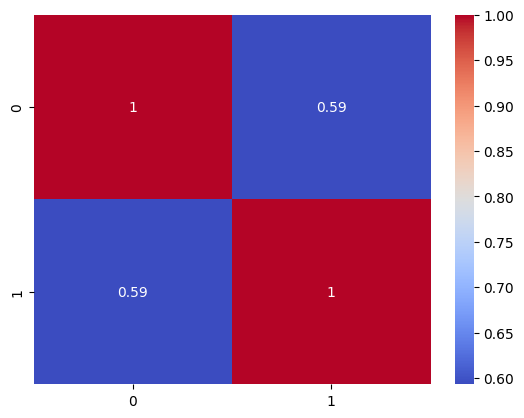

1.9058158279310726

In [ ]:
loss3=Loss
test_loss3=evaluate_model(seq_model)
test_loss3

In [ ]:
text='model without attention: no of hidden layer:1 hidden layer size = 16 embedding size = 16'
model_path='/content/drive/MyDrive/dl_assign2_q1.txt'
write_train_log(loss3,n_epochs,model_path,text)

In [ ]:
n_epochs = 10
learning_rate = 0.001

input_size_encoder = len(english.vocab)
input_size_decoder = len(hindi.vocab)
output_size        = len(hindi.vocab)
embedding_size     = 64
hidden_size        = 64
n_hidden_layers    = 3


encoder_net = Encoder(input_size_encoder,embedding_size,n_hidden_layers,
                      hidden_size).to(device)

decoder_net = Decoder(input_size_decoder,embedding_size,hidden_size,
                      output_size,n_hidden_layers).to(device)

seq_model = seq2seq(encoder_net,decoder_net).to(device)

pad_idx = hindi.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = optim.Adam(seq_model.parameters(), lr=learning_rate)



In [ ]:
Loss=[]
for epoch in range(n_epochs):
  seq_model.train()
  for batch_idx, batch in enumerate(train_iterator):
          train_loss = 0.0
          input_data = batch.input.to(device)
          target_data = batch.output.to(device)
          output = seq_model(input_data,target_data)
          output = output[1:].reshape(-1,output.shape[2])
          target_data=target_data[1:].reshape(-1)

          optimizer.zero_grad()
          loss=criterion(output,target_data)
          loss.backward()

          #avoid exploding gradients
          nn.utils.clip_grad_norm_(seq_model.parameters(),max_norm=1)

          optimizer.step()
          train_loss+=loss.item()

  Loss.append(train_loss)


  print("Epoch:{}/10   Loss:{}".format(epoch+1,train_loss))

Epoch:1/10   Loss:1.183101773262024
Epoch:2/10   Loss:1.2935755252838135
Epoch:3/10   Loss:1.029468297958374
Epoch:4/10   Loss:0.962555468082428
Epoch:5/10   Loss:0.9422837495803833
Epoch:6/10   Loss:0.9571056962013245
Epoch:7/10   Loss:1.0407313108444214
Epoch:8/10   Loss:0.6499488353729248
Epoch:9/10   Loss:0.36466801166534424
Epoch:10/10   Loss:0.6822417974472046


<class 'list'>
<class 'list'>


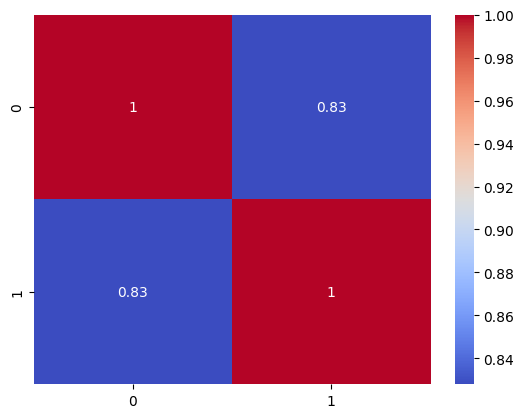

0.7474101181571365

In [ ]:
loss2=Loss
test_loss2=evaluate_model(seq_model)
test_loss2

In [ ]:
text='model without attention: no of hidden layer:3 hidden layer size = 64 embedding size = 64'
model_path='/content/drive/MyDrive/dl_assign2_q1.txt'
write_train_log(loss2,n_epochs,model_path,text)

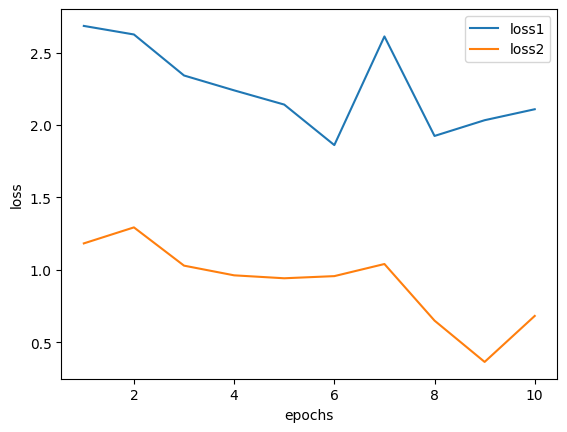

In [ ]:
epochs=[i for i in range(1,n_epochs+1)]
fig, ax = plt.subplots()
ax.plot(epochs, loss3, label='loss1')
ax.plot(epochs, loss2, label='loss2')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.legend()
plt.show()

#LSTM WITH ATTENTION

In [ ]:
class Encoder_attention(nn.Module):

  def __init__(self,input_size,embedding_size,n_hidden_layers,hidden_layer_size,drop_out=0.0):
    super(Encoder_attention,self).__init__()
    self.dropout = nn.Dropout(p=drop_out)
    self.embedding = nn.Embedding(input_size,embedding_size)
    self.lstm = nn.LSTM(embedding_size,hidden_layer_size,n_hidden_layers,bidirectional=True,dropout=drop_out)
    self.fc1 = nn.Linear(hidden_layer_size*2,hidden_layer_size)
    self.fc2 = nn.Linear(hidden_layer_size*2,hidden_layer_size)

  def forward(self,x):
    embedding = self.dropout(self.embedding(x))
    encoder_states,(hidden,cell) = self.lstm(embedding)
    hidden=self.fc1(torch.cat((hidden[0:1],hidden[1:2]),dim=2))
    cell=self.fc1(torch.cat((cell[0:1],cell[1:2]),dim=2))
    return encoder_states,hidden,cell

In [ ]:
class Decoder_attention(nn.Module):

  def __init__(self,input_size,embedding_size,hidden_size,output_size,n_hidden_layers,drop_out=0.0):
    super(Decoder_attention,self).__init__()

    self.dropout=nn.Dropout(p=drop_out)
    self.embedding = nn.Embedding(input_size, embedding_size)
    self.lstm = nn.LSTM(hidden_size*2+embedding_size, hidden_size, n_hidden_layers, dropout=drop_out)
    self.scale = nn.Linear(hidden_size*3,1)
    self.softmax = nn.Softmax(dim=0)
    self.relu = nn.ReLU()
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self,x,encoder_states,hidden,cell):
    x=x.unsqueeze(0)
    embedding = self.dropout(self.embedding(x))

    seq_len = encoder_states.shape[0]
    reshape_seq=hidden.repeat(seq_len,1,1)
    scale=self.relu(self.scale(torch.cat((reshape_seq,encoder_states),dim=2)))
    attention=self.softmax(scale)
    attention=attention.permute(1,2,0)
    encoder_states=encoder_states.permute(1,0,2)
    context_vector=torch.bmm(attention,encoder_states).permute(1,0,2)
    lstm_input=torch.cat((context_vector,embedding),dim=2)

    outputs, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
    out=self.fc(outputs)
    out=out.squeeze(0)

    return out,hidden,cell


In [ ]:
class seq2seq_attention(nn.Module):
  def __init__(self,encoder,decoder):
    super(seq2seq_attention, self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self,src,trg,teacher_force_ratio=0.5):
    batch_size = src.shape[1]
    target_len = trg.shape[0]
    target_word_len=len(hindi.vocab)

    encoder_states,hidden, cell = self.encoder(src)
    outputs = torch.zeros(target_len, batch_size, target_word_len).to(device)

    x = trg[0]

    for t in range(1, target_len):
      output, hidden, cell = self.decoder(x,encoder_states, hidden, cell)
      outputs[t] = output
      predicted_trg = output.argmax(1)
      x = trg[t] if random.random() < teacher_force_ratio else predicted_trg

    return outputs


#####Train

In [ ]:
n_epochs = 10
learning_rate = 0.001

input_size_encoder = len(english.vocab)
input_size_decoder = len(hindi.vocab)
output_size        = len(hindi.vocab)
embedding_size     = 16
hidden_size        = 16
n_hidden_layers    = 1


encoder_net = Encoder_attention(input_size_encoder,embedding_size,n_hidden_layers,
                      hidden_size).to(device)

decoder_net = Decoder_attention(input_size_decoder,embedding_size,hidden_size,
                      output_size,n_hidden_layers).to(device)

seq_model_attention = seq2seq_attention(encoder_net,decoder_net).to(device)

pad_idx = hindi.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = optim.Adam(seq_model.parameters(), lr=learning_rate)



In [ ]:
Loss=[]
for epoch in range(n_epochs):
  seq_model.train()

  for batch_idx, batch in enumerate(train_iterator):
          train_loss = 0.0
          input_data = batch.input.to(device)
          target_data = batch.output.to(device)
          output = seq_model(input_data,target_data)
          output1 = output[1:].reshape(-1,output.shape[2])
          target_data1=target_data[1:].reshape(-1)

          optimizer.zero_grad()
          loss=criterion(output1,target_data1)
          loss.backward()

          #avoid exploding gradients
          nn.utils.clip_grad_norm_(seq_model.parameters(),max_norm=1)

          optimizer.step()
          train_loss+=loss.item()

  Loss.append(train_loss)

  print("Epoch:{}/10   Loss:{} ".format(epoch+1,train_loss))

Epoch:1/10   Loss:1.560520887374878 
Epoch:2/10   Loss:1.699110746383667 
Epoch:3/10   Loss:1.8244853019714355 
Epoch:4/10   Loss:1.9328744411468506 
Epoch:5/10   Loss:1.4553248882293701 
Epoch:6/10   Loss:1.5590728521347046 
Epoch:7/10   Loss:1.8739473819732666 
Epoch:8/10   Loss:1.4631359577178955 
Epoch:9/10   Loss:2.262178421020508 
Epoch:10/10   Loss:1.7918468713760376 


<class 'list'>
<class 'list'>


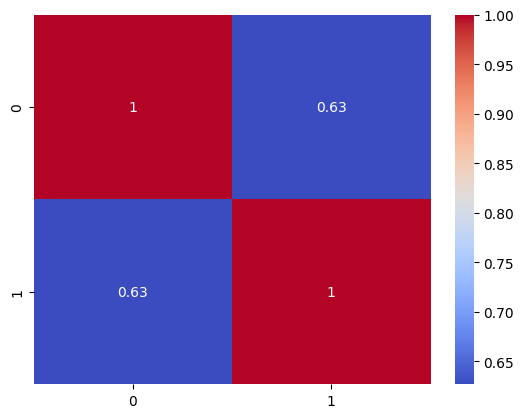

In [ ]:
loss1=Loss
test_loss=evaluate_model(seq_model)

In [ ]:
test_loss

1.7081803125692598

In [ ]:
text='model with attention: no of hidden layer:1 hidden layer size = 16 embedding size = 16'
model_path='/content/drive/MyDrive/dl_assign2_q1.txt'
write_train_log(loss1,10,model_path,text)

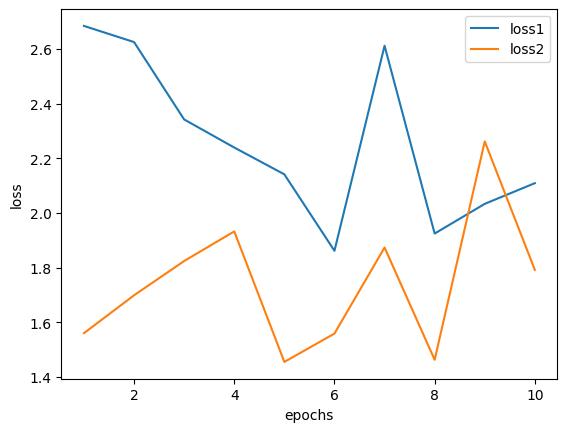

In [ ]:
epochs=[i for i in range(1,n_epochs+1)]
fig, ax = plt.subplots()
ax.plot(epochs, loss3, label='loss1')
ax.plot(epochs, loss1, label='loss2')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.legend()
plt.show()